## Kernel Density Estimation example and initial evidence

If KDE our goal is to take a bunch of vector $v_i$ and be able to esimate the funciton
$$f(x) = \frac{1}{n}\sum_i K(x,v_i)$$

Here the function $K(x,v)$ stand for any positive semidefinite kernel example include
* Gaussian Kernel $\exp(-\|x - v\|^2/\sigma^2)$
* Exponetial Kernel $\exp(-\|x - v\|/\sigma)$
* Cauchy Kernel $1/(1+ \|x - v\|/\sigma)$

We want to do that by choosing subset of the vectors $v_i$ which will represent the entire set. 
We do that in two ways:

1. Sample
2. Create a coreset based on the recent work of Karnin et. al.

### Making data

Here we make data that has $n$ points in $d$ and $k$ centers.
The centers are random points on the unit sphere.
Each point in equal to one of centers plus random gaussian noise to distance noise_level from its center.

In [7]:
from numpy.random import randn
from numpy import zeros, ones, array, sqrt

n = 500 # number of points
d = 100 # the dimension
k = 100 # number of clusters

kernel_type = 'g' #gaussian
kernel_scale = 0.4

centers = randn(k,d)/sqrt(d)

vectors = zeros((n,d))
for i in range(n):
    vectors[i,:] = centers[i%k,:]

noise_level = 0.2
vectors += noise_level*randn(n,d)/sqrt(d)

### Creating coresets/samples.

ds_all contains all the points

ds_coreset contains _at most_ half the points in the original data. This is achived by splitting the data based on the algorithm at Karnin et. al.

ds_sample contains exactly half samples draws uniformaly without replacement. 

## Defining kernel sums and split

In [8]:
from numpy import exp
from numpy.linalg import norm

# Could be replaced with any positive semidefinite kernel 
def kernel_sum(vector, vectors, kernel_type='g', kernel_scale=1.0):
    s = 0.0
    if kernel_type=='g':
        for other in vectors:
            s += exp(-(norm(vector-other)/kernel_scale)**2)
    elif kernel_type=='e':
        for other in vectors:
            s += exp(-(norm(vector-other)/kernel_scale))
    elif kernel_type=='c':
        for other in vectors:
            s += 1.0/(1.0 + norm(vector-other)/kernel_scale)        
    else:
        raise ValueError
    return s

def split(vectors, kernel_type='g', kernel_scale=1.0):
    n = len(vectors)
    set1 = []
    set2 = []
    for i in range(n):
        err = 0.0
        err += kernel_sum(vectors[i], set1, kernel_type, kernel_scale)
        err -= kernel_sum(vectors[i], set2, kernel_type, kernel_scale)
        if err < 0.0:
            set1.append(vectors[i])
        else:
            set2.append(vectors[i])                
    return (set1,set2)

In [9]:
from random import sample


(vectors_coreset1, vectors_coreset2) = split(vectors, kernel_type, kernel_scale)

vectors_sample = sample(list(vectors), int(len(vectors)/2))

### Evaluation

Here, we evaluate the density along a line that goes through two different cluster centers.
The line also extens linearly in both directions.

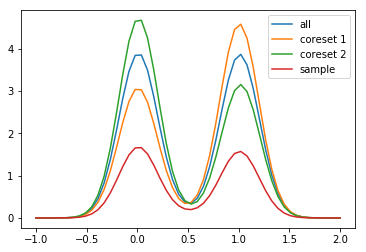

In [10]:
#from math import sqrt
from numpy import linspace
from matplotlib import pyplot as plt


v0 = centers[0]
v1 = centers[1]
m = 50
alphas = linspace(-1.0,2.0,m)
test_vectors = [(1.0-alpha)*v0 + alpha*v1 for alpha in alphas]

evals = zeros((m,4))
for i, test_vector in enumerate(test_vectors):
    evals[i,0] = 1.0*kernel_sum(test_vector, vectors         , kernel_type, kernel_scale)
    evals[i,1] = 2.0*kernel_sum(test_vector, vectors_coreset1, kernel_type, kernel_scale)
    evals[i,2] = 2.0*kernel_sum(test_vector, vectors_coreset2, kernel_type, kernel_scale)
    evals[i,3] = 2.0*kernel_sum(test_vector, vectors_sample  , kernel_type, kernel_scale)
    

plt.plot(alphas, evals[:,0], label='all')
plt.plot(alphas, evals[:,1], label='coreset 1')
plt.plot(alphas, evals[:,2], label='coreset 2')
plt.plot(alphas, evals[:,3], label='sample')
plt.legend()

### Results
On the $x$ axis you get the linear combination of centers. $x=0$ corresponds to the first center and $x=1$ to the second. The $y$ axis give the real density and the estimated density in the two methods.

You should see that the lines called 'all' and 'coreset' follow eachother much more closely.
The line called 'sampeled' is usually further away.

The coreset is a actually much smaller than the sample size... not sure how to fix that or take advantage of the extra capacity...